# Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

In [2]:
engine = create_engine('sqlite:///instance/logs.db')

def query_db(query):
    return pd.read_sql_query(query, engine)

In [3]:
df = query_db('SELECT * FROM daily_production;')
df

,id,production_date,bag_type_id,quantity,updated_at
0,1,2024-08-01,1,29,2025-02-21 19:10:55.859115
1,2,2024-08-02,1,18,2025-02-21 19:10:55.859115
2,3,2024-08-03,1,31,2025-02-21 19:10:55.859115
3,4,2024-08-04,1,18,2025-02-21 19:10:55.859115
4,5,2024-08-05,1,11,2025-02-21 19:10:55.859115
...,...,...,...,...,...
301,302,2024-12-27,2,12,2025-02-21 19:10:55.859115
302,303,2024-12-28,2,16,2025-02-21 19:10:55.859115
303,304,2024-12-29,2,19,2025-02-21 19:10:55.859115
304,305,2024-12-30,2,37,2025-02-21 19:10:55.859115


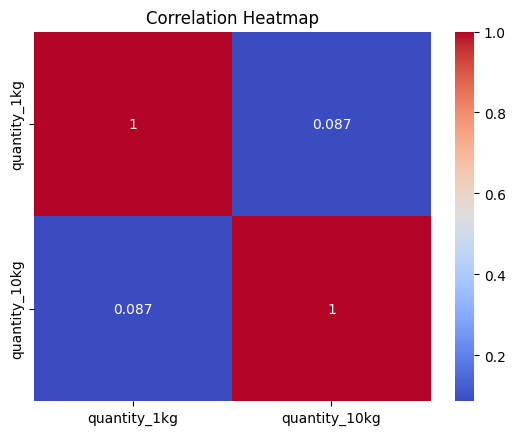

In [4]:
one_kg_df = df[df['bag_type_id'] == 1].copy()
ten_kg_df = df[df['bag_type_id'] == 2].copy()
merged_df = pd.merge(one_kg_df[['production_date', 'quantity']], ten_kg_df[['production_date', 'quantity']], on='production_date', suffixes=('_1kg', '_10kg'))

# Calculate the correlation between the quantities
correlation = merged_df['quantity_1kg'].corr(merged_df['quantity_10kg'])

# Create a correlation matrix
corr_matrix = merged_df[['quantity_1kg', 'quantity_10kg']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [5]:
merged_df

,production_date,quantity_1kg,quantity_10kg
0,2024-08-01,29,17
1,2024-08-02,18,23
2,2024-08-03,31,28
3,2024-08-04,18,32
4,2024-08-05,11,20
...,...,...,...
148,2024-12-27,17,12
149,2024-12-28,9,16
150,2024-12-29,21,19
151,2024-12-30,14,37


In [6]:
one_kg_df.drop(['bag_type_id', 'id', 'updated_at'], axis=1, inplace=True)
one_kg_df['production_date'] = pd.to_datetime(one_kg_df['production_date'])
ten_kg_df.drop(['bag_type_id', 'id', 'updated_at'], axis=1, inplace=True)
ten_kg_df['production_date'] = pd.to_datetime(ten_kg_df['production_date'])


print(one_kg_df.head())
print(ten_kg_df.head())

  production_date  quantity
0      2024-08-01        29
1      2024-08-02        18
2      2024-08-03        31
3      2024-08-04        18
4      2024-08-05        11
   production_date  quantity
31      2024-08-01        17
32      2024-08-02        23
33      2024-08-03        28
34      2024-08-04        32
35      2024-08-05        20


# Training

In [7]:
import pickle
from pmdarima import auto_arima
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter('ignore', FutureWarning)

## 1 kg Bags

In [8]:
one_kg_parameters = auto_arima(one_kg_df['quantity'], seasonal=True, m=7, stepwise=True, trace=True)
print(one_kg_parameters.order, one_kg_parameters.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1101.923, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1067.835, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1024.537, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1099.925, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1025.919, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=1026.537, Time=0.15 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=1026.537, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=1024.666, Time=0.10 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=1100.960, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1026.528, Time=0.16 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=1026.526, Time=0.16 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1067.728, Time=0.14 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=i

In [ ]:
#@title Rolling Forecast
forecast_window_days = 60
rolling_forecast_df = pd.DataFrame(index=pd.date_range(one_kg_df['production_date'].iloc[-1] + timedelta(days=1), periods=30, freq="D"))
history = one_kg_df["quantity"][-forecast_window_days:]
predictions = []

for i in range(30):
    # Train a new SARIMA model using only the last 6 months
    rolling_model = SARIMAX(history, order=one_kg_parameters.order, seasonal_order=one_kg_parameters.seasonal_order).fit()
    
    # Predict the next day's sales
    forecast = rolling_model.forecast()
    predictions.append(round(forecast.values[0]))
    
    # Append forecasted value to history for the next iteration
    history = pd.concat([history, pd.Series(forecast.values[0], index=[rolling_forecast_df.index[i]])])

# Store the forecasts in DataFrame
rolling_forecast_df["1kg_forecast"] = predictions
rolling_forecast_df

    production_date  quantity
185      2024-11-02         7
186      2024-11-03        10
187      2024-11-04         9
188      2024-11-05         6
189      2024-11-06         6
190      2024-11-07         8
191      2024-11-08         8
192      2024-11-09        12
193      2024-11-10        10
194      2024-11-11         9
195      2024-11-12        10
196      2024-11-13        13
197      2024-11-14         8
198      2024-11-15         5
199      2024-11-16        10
200      2024-11-17        11
201      2024-11-18         7
202      2024-11-19         8
203      2024-11-20         4
204      2024-11-21        11
205      2024-11-22        14
206      2024-11-23         6
207      2024-11-24         8
208      2024-11-25        10
209      2024-11-26         8
210      2024-11-27         5
211      2024-11-28         9
212      2024-11-29         9
213      2024-11-30        -7
244      2024-12-01        15
245      2024-12-02        12
246      2024-12-03        15
247      2

c:\Users\ACER\OneDrive\Documents\Python\Flask Projects\MangUling\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ACER\OneDrive\Documents\Python\Flask Projects\MangUling\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ACER\OneDrive\Documents\Python\Flask Projects\MangUling\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ACER\OneDrive\Documents\Python\Flask Projects\MangUlin

,1kg_forecast
2025-01-01,15
2025-01-02,9
2025-01-03,15
2025-01-04,13
2025-01-05,16
2025-01-06,15
2025-01-07,17
2025-01-08,15
2025-01-09,14
2025-01-10,15


## 10 Kg Bags


In [1]:
ten_kg_parameters = auto_arima(ten_kg_df['quantity'], seasonal=True, m=7, stepwise=True, trace=True)

print(ten_kg_parameters.order, ten_kg_parameters.seasonal_order)

NameError: name 'auto_arima' is not defined

In [43]:
ten_kg_df.describe()

,production_date,quantity
count,153,153.000000
mean,2024-10-16 00:00:00,28.104575
min,2024-08-01 00:00:00,-60.000000
25%,2024-09-08 00:00:00,22.000000
50%,2024-10-16 00:00:00,28.000000
75%,2024-11-23 00:00:00,34.000000
max,2024-12-31 00:00:00,104.000000
std,NaN,13.691701


In [40]:
#@title Rolling Forecast
forecast_window_days = 180

rolling_forecast_df = pd.DataFrame(index=pd.date_range(ten_kg_df['production_date'].iloc[-1] + timedelta(days=1), periods=30, freq="D"))

history = ten_kg_df["quantity"][-forecast_window_days:]
predictions = []

for i in range(30):
    # Train a new SARIMA model using only the last 6 months
    rolling_model = SARIMAX(history, order=ten_kg_parameters.order, seasonal_order=ten_kg_parameters.seasonal_order).fit()
    
    # Predict the next day's sales
    forecast = rolling_model.forecast()
    predictions.append(forecast.values[0])

    # Append forecasted value to history for the next iteration
    history = pd.concat([history, pd.Series(forecast.values[0], index=[rolling_forecast_df.index[i]])])

# Store the forecasts in DataFrame
rolling_forecast_df["10kg_forecast"] = predictions
rolling_forecast_df

c:\Users\ACER\OneDrive\Documents\Python\Flask Projects\MangUling\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ACER\OneDrive\Documents\Python\Flask Projects\MangUling\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ACER\OneDrive\Documents\Python\Flask Projects\MangUling\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ACER\OneDrive\Documents\Python\Flask Projects\MangU

,10kg_forecast
2025-01-01,0.0
2025-01-02,0.0
2025-01-03,0.0
2025-01-04,0.0
2025-01-05,0.0
2025-01-06,0.0
2025-01-07,0.0
2025-01-08,0.0
2025-01-09,0.0
2025-01-10,0.0
